In [1]:
import os
import random
import easydict
import requests
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Baseline

## 설계

### Baseline 코드
- https://www.kaggle.com/code/girinman/hai2023-pytorch
- Baseline을 제공해주신 운영진분들께 감사함을 표합니다!

### Baseline 일부 수정

- 로컬에서 작업하여 일부 경로 수정
- 모델 및 파라미터 변경을 통해 실험 진행
- 주피터 노트북의 불편성으로 편의를 위해 대부분 기능을 함수화
- 함수화를 통해 인자값을 편하게 바꾸며, 모델 가중치 및 제출 파일 저장 가능


    <kbd>
    
    ```python
    # 예시코드
    # 아래의 부분의 값만 바꾸면서 실험 가능
    ############################################
    args = easydict.EasyDict({
        "train_path": "./train.csv",
        "valid_path": "./valid.csv",
        "device" : 'cpu',
        "mode" : "train",
        "batch" : 64,
        "maxlen" : 32,
        "lr" : 1e-3,
        "eps" : 1e-8,
        "epochs" : 1,
        "model_ckpt" : "monologg/distilkobert",
    })
    
    test_args = easydict.EasyDict({
      "device" : "cpu",
      "mode" : "test",
      "batch" : 64,
      "maxlen" : 32,
    })
    ############################################
    
    model, tokenizer, train_accuracies, val_accuracies = train_valid(args)
    test(model, tokenizer, test_args, "./test.csv", args)
    
    ```
    </kbd>

    - 위 코드의 인자값만 바꿔주면 실험 가능

### 기능적 추가

- 무한정 epoch이 도는 동안 기다릴 수 없기에, 10번이상 val_acc가 나아지지 않는다면 멈추도록 early_stopping 추가(val_acc 기준)
  
- train_valid 결과를 시각화를 통해 주피터 노트북에서도 편하게 확인하는 코드 추가
      
- 실험 결과 정리를 위해 Tensorboard 활용
    - 이전까지는 엑셀에 기록하였음(오랜만에 실험이라 존재를 잊고 있었다...)
        - https://docs.google.com/spreadsheets/d/1ccbpJsApRetUQEyO0pTmH_sceuOWyBM1DDaO7yG8Ev4/edit?usp=sharing
        - 기록하다가 갑자기 아 맞다 텐서보드...
        - 참고: https://tutorials.pytorch.kr/recipes/recipes/tensorboard_with_pytorch.html

    - 만약 텐서보드를 어떻게 사용하는지 궁금하다면?
        - 현재 github clone
          
        - 결과물 확인하기
          - 현재 경로로 이동(폴더 이름: hai_summer_kaggle)
          
          <kbd>
        
          ```bash
          cd ./hai_summer_kaggle
          tensorboard --logdir=hai_summer_kaggle_tensorboard
          ```
          </kbd>
    
        - 이후 포트 번호를 통해 편하게 모든 결과 확인.
            - e.g.
              <kbd>
            
              ```bash
              http://localhost:6006/
              ```
              </kbd> 

## func

### generate_data_loader

In [2]:
def generate_data_loader(file_path, tokenizer, args):

    def get_input_ids(data):
        document_bert = ["[CLS] " + str(s) + " [SEP]" for s in data]
        tokenized_texts = [tokenizer.tokenize(s) for s in tqdm(document_bert, "Tokenizing")]
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts, "Converting tokens to ids")]
        print("Padding sequences...")
        input_ids = pad_sequences(input_ids, maxlen=args.maxlen, dtype='long', truncating='post', padding='post')
        return input_ids

    def get_attention_masks(input_ids):
        attention_masks = []
        for seq in tqdm(input_ids, "Generating attention masks"):
            seq_mask = [float(i > 0) for i in seq]
            attention_masks.append(seq_mask)
        return attention_masks

    def get_data_loader(inputs, masks, labels, batch_size=args.batch):
        data = TensorDataset(torch.tensor(inputs), torch.tensor(masks), torch.tensor(labels))
        sampler = RandomSampler(data) if args.mode == 'train' else SequentialSampler(data)
        data_loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return data_loader

    data_df = pd.read_csv(file_path)
    input_ids = get_input_ids(data_df['text'].values)
    attention_masks = get_attention_masks(input_ids)
    data_loader = get_data_loader(input_ids, attention_masks, data_df['label'].values if args.mode=='train' else [-1]*len(data_df))

    return data_loader

### save&flat_accuracy

In [3]:
def save(model, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(dir_name, 'model.pth'))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### predict

In [4]:
def predict(model, args, data_loader):
    print('start predict')
    model.eval()

    eval_loss = []
    eval_accuracy = []
    logits = []

    for step, batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(args.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            if args.mode == 'test':
                outputs = model(b_input_ids, attention_mask=b_input_mask)
                logit = outputs[0]
            else:
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss, logit = outputs[:2]
                eval_loss.append(loss.item())

        logit = logit.detach().cpu().numpy()
        label = b_labels.cpu().numpy()

        logits.append(logit)

        if args.mode != 'test':
            accuracy = flat_accuracy(logit, label)
            eval_accuracy.append(accuracy)

    logits = np.vstack(logits)
    predict_labels = np.argmax(logits, axis=1)

    if args.mode == 'test':
        return predict_labels, None

    avg_eval_loss = np.mean(eval_loss)
    avg_eval_accuracy = np.mean(eval_accuracy)

    return predict_labels, avg_eval_loss, avg_eval_accuracy

### train

In [5]:
def train(model, args, train_loader, valid_loader, patience=5):
    experiment_name = f"model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}"
    writer = SummaryWriter(f'hai_kaggle/{experiment_name}')

    optimizer = AdamW(model.parameters(),
                      lr=args.lr,
                      eps=args.eps
                      )
    total_steps = len(train_loader) * args.epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    best_val_accuracy = 0.0
    best_train_accuracy = 0.0
    epochs_without_improvement = 0

    train_accuracies = []
    val_accuracies = []

    print('start training')
    for epoch in range(args.epochs):
        model.train()
        train_loss = []
        for step, batch in tqdm(enumerate(train_loader), f"training epoch {epoch}", total=len(train_loader)):
            model.zero_grad()
            batch = tuple(t.to(args.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs[0]
            train_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            writer.add_scalar('training loss',
                            loss.item(),
                            epoch * len(train_loader) + step)

        avg_train_loss = np.mean(train_loss)
        _, _, avg_train_accuracy = predict(model, args, train_loader)
        _, _, avg_val_accuracy = predict(model, args, valid_loader)
        print("Epoch {0},  Average training loss: {1:.4f} , Train accuracy : {2:.4f}, Validation accuracy : {3:.4f}"
              .format(epoch, avg_train_loss, avg_train_accuracy, avg_val_accuracy))

        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)

        writer.add_scalar('training accuracy',
                        avg_train_accuracy,
                        epoch)
        writer.add_scalar('validation accuracy',
                        avg_val_accuracy,
                        epoch)

        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_train_accuracy = avg_train_accuracy
            epochs_without_improvement = 0
            save_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}"
            save(model, save_path)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"[Early Stopping]{patience} epoch에서 중단.[Early Stopping]")
            break

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    model_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/model.pth"
    model.load_state_dict(torch.load(model_path))

    print(f"Best Train Accuracy: {best_train_accuracy}, Best Validation Accuracy: {best_val_accuracy}")

    writer.add_hparams({
        'lr': args.lr,
        'eps': args.eps,
        'batch': args.batch,
        'epochs': args.epochs,
        'maxlen': args.maxlen
        }, {
        'best_train_accuracy': best_train_accuracy,
        'best_val_accuracy': best_val_accuracy
        })

    writer.close()
    return model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies

### train_valid

In [6]:
def train_valid(args):
    if torch.cuda.is_available():
        args.device = 'cuda'
    else:
        args.device = 'cpu'

    model = AutoModelForSequenceClassification.from_pretrained(args.model_ckpt, num_labels=3)
    model.to(args.device)
    tokenizer = AutoTokenizer.from_pretrained(args.model_ckpt)

    train_dataloader = generate_data_loader(args.train_path, tokenizer, args)
    validation_dataloader = generate_data_loader(args.valid_path, tokenizer, args)

    model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies = train(model, args, train_dataloader, validation_dataloader)

    return model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy

### test

In [7]:
# best_train_accuracy & best_val_accuracy는 모델 경로 때문에 주는 것임!
def test(model, tokenizer, test_args, file_path, args, best_train_accuracy, best_val_accuracy):
    if torch.cuda.is_available():
        test_args.device = 'cuda'

    test_dataloader = generate_data_loader(file_path, tokenizer=tokenizer, args=test_args)
    labels, _ = predict(model, test_args, test_dataloader)

    submit_df = pd.DataFrame()
    submit_df["idx"] = range(len(labels))
    submit_df["label"] = labels
    save_path = f"./saved_checkpoints/best_model/model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/submission.csv"
    submit_df.to_csv(save_path, index=False)
    print(f"Submission file saved to {save_path}")

# 파라미터 조정 및 모델 변경

## batch_size/maxlen/lr/eps/epoch

## distilkobert

### 64/32/1.00E-03/1.00E-08/1

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at monologg/distilkobert and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 338655.10it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 361283.44it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 160292.92it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [02:09<00:00, 23.09it/s]


start predict


2981it [00:45, 64.99it/s]


start predict


16it [00:00, 69.36it/s]


Epoch 0,  Average training loss: 0.8661 , Train accuracy : 0.6145, Validation accuracy : 0.5990


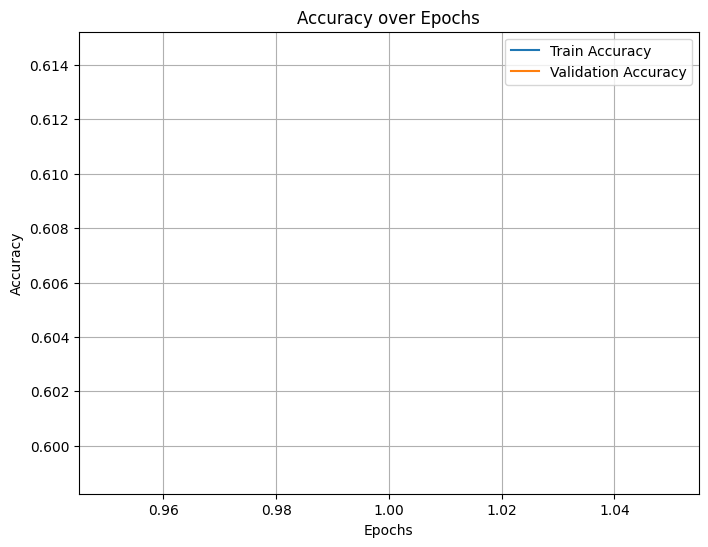

Best Train Accuracy: 0.6144508973498826, Best Validation Accuracy: 0.5990084134615384


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 438702.47it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 162658.55it/s]


start predict


10it [00:00, 79.55it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_distilkobert_lr_0.001_batch_64_epochs_1_maxlen_32_eps_1e-08_TrainAcc_0.6144508973498826_ValAcc_0.5990084134615384/submission.csv


In [8]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 1e-3,
    "eps" : 1e-8,
    "epochs" : 1,
    "model_ckpt" : "monologg/distilkobert",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 64/32/3.00E-05/1.00E-08/50

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at monologg/distilkobert and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 269301.51it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 408800.74it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 149917.63it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [02:08<00:00, 23.12it/s]


start predict


2981it [00:46, 63.69it/s]


start predict


16it [00:00, 69.34it/s]


Epoch 0,  Average training loss: 0.8540 , Train accuracy : 0.6168, Validation accuracy : 0.6067


training epoch 1: 100%|█████████████████████| 2981/2981 [02:10<00:00, 22.85it/s]


start predict


2981it [00:47, 63.27it/s]


start predict


16it [00:00, 69.78it/s]


Epoch 1,  Average training loss: 0.8147 , Train accuracy : 0.6223, Validation accuracy : 0.6010


training epoch 2: 100%|█████████████████████| 2981/2981 [02:10<00:00, 22.81it/s]


start predict


2981it [00:47, 63.33it/s]


start predict


16it [00:00, 69.10it/s]


Epoch 2,  Average training loss: 0.8028 , Train accuracy : 0.6263, Validation accuracy : 0.6154


training epoch 3: 100%|█████████████████████| 2981/2981 [02:10<00:00, 22.80it/s]


start predict


2981it [00:47, 63.22it/s]


start predict


16it [00:00, 68.73it/s]


Epoch 3,  Average training loss: 0.7946 , Train accuracy : 0.6306, Validation accuracy : 0.6001


training epoch 4: 100%|█████████████████████| 2981/2981 [02:10<00:00, 22.78it/s]


start predict


2981it [00:47, 63.32it/s]


start predict


16it [00:00, 69.93it/s]


Epoch 4,  Average training loss: 0.7871 , Train accuracy : 0.6336, Validation accuracy : 0.5971


training epoch 5: 100%|█████████████████████| 2981/2981 [02:10<00:00, 22.77it/s]


start predict


2981it [00:47, 63.29it/s]


start predict


16it [00:00, 69.26it/s]


Epoch 5,  Average training loss: 0.7787 , Train accuracy : 0.6414, Validation accuracy : 0.5788


training epoch 6: 100%|█████████████████████| 2981/2981 [02:11<00:00, 22.74it/s]


start predict


2981it [00:47, 63.23it/s]


start predict


16it [00:00, 68.55it/s]


Epoch 6,  Average training loss: 0.7717 , Train accuracy : 0.6457, Validation accuracy : 0.6048


training epoch 7: 100%|█████████████████████| 2981/2981 [02:10<00:00, 22.76it/s]


start predict


2981it [00:47, 63.38it/s]


start predict


16it [00:00, 69.11it/s]


Epoch 7,  Average training loss: 0.7626 , Train accuracy : 0.6544, Validation accuracy : 0.5777


training epoch 8: 100%|█████████████████████| 2981/2981 [02:11<00:00, 22.75it/s]


start predict


2981it [00:47, 63.13it/s]


start predict


16it [00:00, 68.79it/s]


Epoch 8,  Average training loss: 0.7543 , Train accuracy : 0.6592, Validation accuracy : 0.5989


training epoch 9: 100%|█████████████████████| 2981/2981 [02:12<00:00, 22.55it/s]


start predict


2981it [00:47, 62.54it/s]


start predict


16it [00:00, 68.98it/s]


Epoch 9,  Average training loss: 0.7458 , Train accuracy : 0.6661, Validation accuracy : 0.5845


training epoch 10: 100%|████████████████████| 2981/2981 [02:09<00:00, 23.02it/s]


start predict


2981it [00:45, 65.00it/s]


start predict


16it [00:00, 71.61it/s]


Epoch 10,  Average training loss: 0.7373 , Train accuracy : 0.6711, Validation accuracy : 0.5893


training epoch 11: 100%|████████████████████| 2981/2981 [02:07<00:00, 23.31it/s]


start predict


2981it [00:46, 64.66it/s]


start predict


16it [00:00, 70.43it/s]


Epoch 11,  Average training loss: 0.7296 , Train accuracy : 0.6796, Validation accuracy : 0.5777


training epoch 12: 100%|████████████████████| 2981/2981 [02:08<00:00, 23.26it/s]


start predict


2981it [00:46, 64.76it/s]


start predict


16it [00:00, 71.17it/s]


Epoch 12,  Average training loss: 0.7222 , Train accuracy : 0.6853, Validation accuracy : 0.5892
[Early Stopping]10 epoch에서 중단.[Early Stopping]


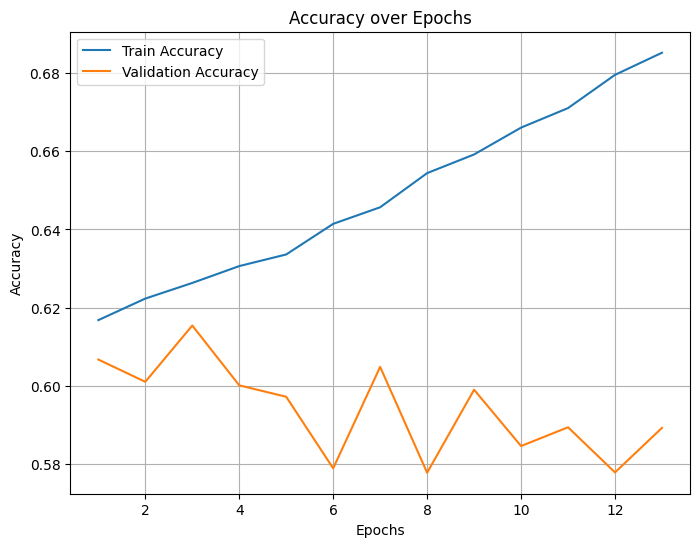

Best Train Accuracy: 0.6262915129151291, Best Validation Accuracy: 0.6153846153846154


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 445249.16it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 164595.93it/s]


start predict


10it [00:00, 77.08it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_distilkobert_lr_3e-05_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.6262915129151291_ValAcc_0.6153846153846154/submission.csv


In [9]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/distilkobert",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

## koelectra-small-v3-discriminator

### 64/32/1.00E-03/1.00E-08/1

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 220687.62it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 264385.71it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 163229.25it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [01:37<00:00, 30.47it/s]


start predict


2981it [00:30, 98.54it/s] 


start predict


16it [00:00, 103.90it/s]


Epoch 0,  Average training loss: 0.9719 , Train accuracy : 0.5793, Validation accuracy : 0.5600


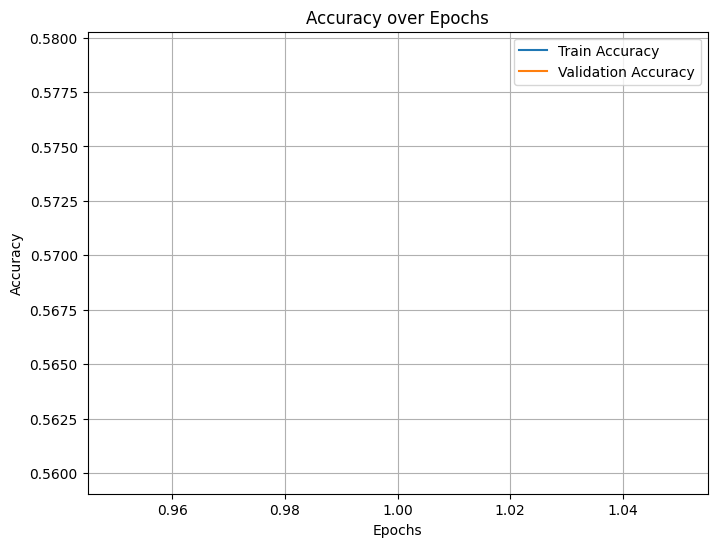

Best Train Accuracy: 0.579305392485743, Best Validation Accuracy: 0.5600210336538461


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 243181.84it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 166063.77it/s]


start predict


10it [00:00, 102.15it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_0.001_batch_64_epochs_1_maxlen_32_eps_1e-08_TrainAcc_0.579305392485743_ValAcc_0.5600210336538461/submission.csv


In [10]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 1e-3,
    "eps" : 1e-8,
    "epochs" : 1,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 128/32/1.00E-03/1.00E-08/1

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:01<00:00, 190618.88it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 260853.81it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 162268.70it/s]


start training


training epoch 0: 100%|█████████████████████| 1491/1491 [01:27<00:00, 16.97it/s]


start predict


1491it [00:28, 51.53it/s]


start predict


8it [00:00, 53.74it/s]


Epoch 0,  Average training loss: 0.9725 , Train accuracy : 0.5793, Validation accuracy : 0.5604


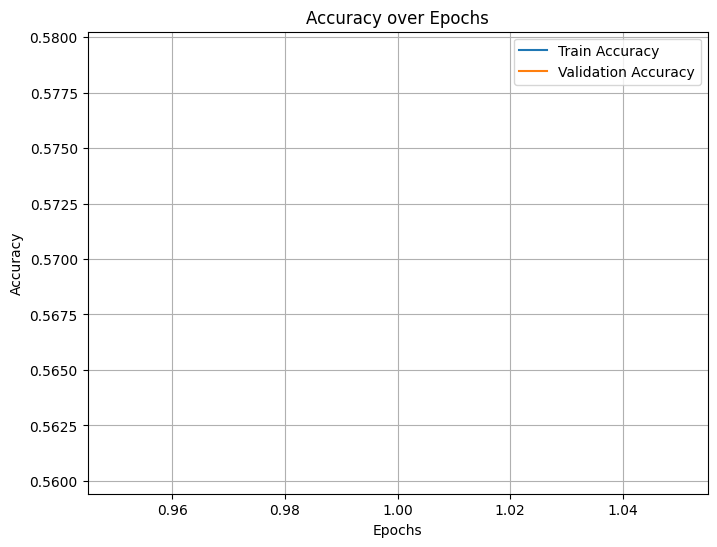

Best Train Accuracy: 0.5792955650570087, Best Validation Accuracy: 0.5603693181818181


Converting tokens to ids: 100%|████████████| 626/626 [00:00<00:00, 96378.31it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 626/626 [00:00<00:00, 76847.08it/s]


start predict


5it [00:00, 52.71it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_0.001_batch_128_epochs_1_maxlen_32_eps_1e-08_TrainAcc_0.5792955650570087_ValAcc_0.5603693181818181/submission.csv


In [11]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 128,
    "maxlen" : 32,
    "lr" : 1e-3,
    "eps" : 1e-8,
    "epochs" : 1,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 64/32/3.00E-05/1.00E-08/1

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:01<00:00, 184727.58it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 242026.91it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 161459.80it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [01:40<00:00, 29.57it/s]


start predict


2981it [00:30, 97.10it/s]


start predict


16it [00:00, 102.06it/s]


Epoch 0,  Average training loss: 0.3582 , Train accuracy : 0.9216, Validation accuracy : 0.9054


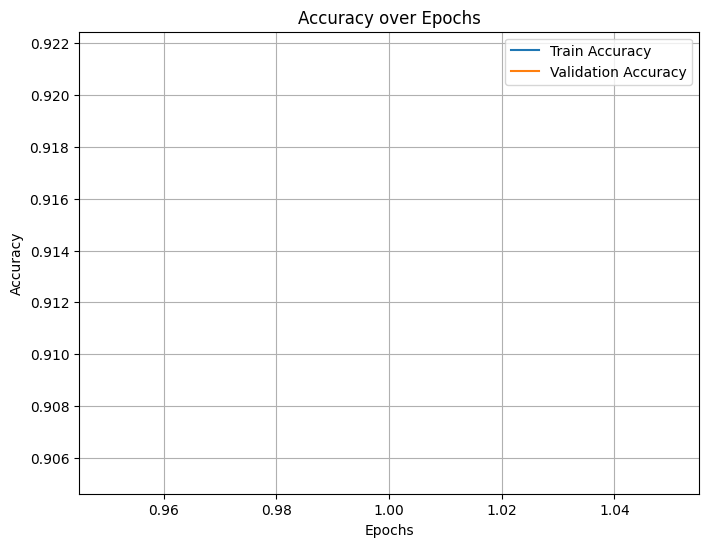

Best Train Accuracy: 0.9216359862462261, Best Validation Accuracy: 0.9054236778846154


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 145223.14it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 156492.69it/s]


start predict


10it [00:00, 100.65it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_64_epochs_1_maxlen_32_eps_1e-08_TrainAcc_0.9216359862462261_ValAcc_0.9054236778846154/submission.csv


In [12]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 1,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### ★★★ 64/32/3.00E-05/1.00E-08/50

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 221793.80it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 242429.48it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 152745.63it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [01:39<00:00, 29.99it/s]


start predict


2981it [00:30, 98.52it/s]


start predict


16it [00:00, 103.57it/s]


Epoch 0,  Average training loss: 0.3446 , Train accuracy : 0.9300, Validation accuracy : 0.9093


training epoch 1: 100%|█████████████████████| 2981/2981 [01:39<00:00, 29.88it/s]


start predict


2981it [00:30, 98.50it/s]


start predict


16it [00:00, 105.65it/s]


Epoch 1,  Average training loss: 0.2177 , Train accuracy : 0.9436, Validation accuracy : 0.9180


training epoch 2: 100%|█████████████████████| 2981/2981 [01:39<00:00, 29.93it/s]


start predict


2981it [00:30, 99.00it/s] 


start predict


16it [00:00, 105.67it/s]


Epoch 2,  Average training loss: 0.1857 , Train accuracy : 0.9526, Validation accuracy : 0.9220


training epoch 3: 100%|█████████████████████| 2981/2981 [01:39<00:00, 29.95it/s]


start predict


2981it [00:30, 98.61it/s] 


start predict


16it [00:00, 104.35it/s]


Epoch 3,  Average training loss: 0.1637 , Train accuracy : 0.9601, Validation accuracy : 0.9200


training epoch 4: 100%|█████████████████████| 2981/2981 [01:39<00:00, 29.91it/s]


start predict


2981it [00:30, 98.44it/s]


start predict


16it [00:00, 103.24it/s]


Epoch 4,  Average training loss: 0.1472 , Train accuracy : 0.9668, Validation accuracy : 0.9238


training epoch 5: 100%|█████████████████████| 2981/2981 [01:39<00:00, 29.95it/s]


start predict


2981it [00:30, 99.15it/s] 


start predict


16it [00:00, 107.41it/s]


Epoch 5,  Average training loss: 0.1320 , Train accuracy : 0.9709, Validation accuracy : 0.9268


training epoch 6: 100%|█████████████████████| 2981/2981 [01:39<00:00, 30.08it/s]


start predict


2981it [00:30, 99.26it/s] 


start predict


16it [00:00, 106.38it/s]


Epoch 6,  Average training loss: 0.1192 , Train accuracy : 0.9769, Validation accuracy : 0.9240


training epoch 7: 100%|█████████████████████| 2981/2981 [01:39<00:00, 30.08it/s]


start predict


2981it [00:30, 99.01it/s]


start predict


16it [00:00, 103.76it/s]


Epoch 7,  Average training loss: 0.1091 , Train accuracy : 0.9792, Validation accuracy : 0.9268


training epoch 8: 100%|█████████████████████| 2981/2981 [01:36<00:00, 30.76it/s]


start predict


2981it [00:28, 104.58it/s]


start predict


16it [00:00, 108.72it/s]


Epoch 8,  Average training loss: 0.0972 , Train accuracy : 0.9844, Validation accuracy : 0.9240


training epoch 9: 100%|█████████████████████| 2981/2981 [01:39<00:00, 30.09it/s]


start predict


2981it [00:29, 99.48it/s] 


start predict


16it [00:00, 105.50it/s]


Epoch 9,  Average training loss: 0.0884 , Train accuracy : 0.9869, Validation accuracy : 0.9346


training epoch 10: 100%|████████████████████| 2981/2981 [01:39<00:00, 30.11it/s]


start predict


2981it [00:29, 99.47it/s] 


start predict


16it [00:00, 105.23it/s]


Epoch 10,  Average training loss: 0.0802 , Train accuracy : 0.9883, Validation accuracy : 0.9316


training epoch 11: 100%|████████████████████| 2981/2981 [01:38<00:00, 30.37it/s]


start predict


2981it [00:28, 104.59it/s]


start predict


16it [00:00, 109.95it/s]


Epoch 11,  Average training loss: 0.0724 , Train accuracy : 0.9898, Validation accuracy : 0.9365


training epoch 12: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.28it/s]


start predict


2981it [00:28, 104.47it/s]


start predict


16it [00:00, 110.06it/s]


Epoch 12,  Average training loss: 0.0665 , Train accuracy : 0.9929, Validation accuracy : 0.9288


training epoch 13: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.28it/s]


start predict


2981it [00:28, 104.49it/s]


start predict


16it [00:00, 107.68it/s]


Epoch 13,  Average training loss: 0.0601 , Train accuracy : 0.9938, Validation accuracy : 0.9259


training epoch 14: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.30it/s]


start predict


2981it [00:28, 104.46it/s]


start predict


16it [00:00, 110.06it/s]


Epoch 14,  Average training loss: 0.0563 , Train accuracy : 0.9956, Validation accuracy : 0.9365


training epoch 15: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.33it/s]


start predict


2981it [00:28, 104.52it/s]


start predict


16it [00:00, 110.45it/s]


Epoch 15,  Average training loss: 0.0513 , Train accuracy : 0.9961, Validation accuracy : 0.9365


training epoch 16: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.28it/s]


start predict


2981it [00:28, 104.56it/s]


start predict


16it [00:00, 110.06it/s]


Epoch 16,  Average training loss: 0.0480 , Train accuracy : 0.9964, Validation accuracy : 0.9424


training epoch 17: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.33it/s]


start predict


2981it [00:28, 104.62it/s]


start predict


16it [00:00, 109.64it/s]


Epoch 17,  Average training loss: 0.0442 , Train accuracy : 0.9972, Validation accuracy : 0.9307


training epoch 18: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.28it/s]


start predict


2981it [00:28, 104.57it/s]


start predict


16it [00:00, 107.82it/s]


Epoch 18,  Average training loss: 0.0411 , Train accuracy : 0.9974, Validation accuracy : 0.9269


training epoch 19: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.31it/s]


start predict


2981it [00:28, 104.61it/s]


start predict


16it [00:00, 108.76it/s]


Epoch 19,  Average training loss: 0.0387 , Train accuracy : 0.9979, Validation accuracy : 0.9288


training epoch 20: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.28it/s]


start predict


2981it [00:28, 104.57it/s]


start predict


16it [00:00, 110.49it/s]


Epoch 20,  Average training loss: 0.0360 , Train accuracy : 0.9980, Validation accuracy : 0.9327


training epoch 21: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.29it/s]


start predict


2981it [00:28, 104.53it/s]


start predict


16it [00:00, 109.34it/s]


Epoch 21,  Average training loss: 0.0333 , Train accuracy : 0.9984, Validation accuracy : 0.9326


training epoch 22: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.31it/s]


start predict


2981it [00:28, 104.41it/s]


start predict


16it [00:00, 110.53it/s]


Epoch 22,  Average training loss: 0.0323 , Train accuracy : 0.9986, Validation accuracy : 0.9346


training epoch 23: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.32it/s]


start predict


2981it [00:28, 104.47it/s]


start predict


16it [00:00, 109.24it/s]


Epoch 23,  Average training loss: 0.0288 , Train accuracy : 0.9987, Validation accuracy : 0.9355


training epoch 24: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.32it/s]


start predict


2981it [00:28, 104.49it/s]


start predict


16it [00:00, 111.34it/s]


Epoch 24,  Average training loss: 0.0274 , Train accuracy : 0.9989, Validation accuracy : 0.9259


training epoch 25: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.31it/s]


start predict


2981it [00:28, 104.56it/s]


start predict


16it [00:00, 110.10it/s]


Epoch 25,  Average training loss: 0.0258 , Train accuracy : 0.9988, Validation accuracy : 0.9316


training epoch 26: 100%|████████████████████| 2981/2981 [01:35<00:00, 31.30it/s]


start predict


2981it [00:28, 104.43it/s]


start predict


16it [00:00, 109.98it/s]


Epoch 26,  Average training loss: 0.0250 , Train accuracy : 0.9990, Validation accuracy : 0.9288
[Early Stopping]10 epoch에서 중단.[Early Stopping]


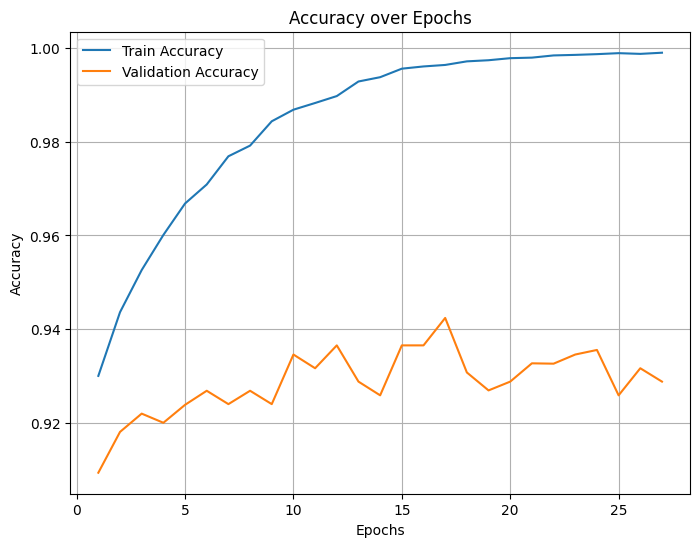

Best Train Accuracy: 0.9964095521637034, Best Validation Accuracy: 0.9423828125


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 235736.60it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 160973.23it/s]


start predict


10it [00:00, 108.65it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.9964095521637034_ValAcc_0.9423828125/submission.csv


In [13]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 128/32/3.00E-05/1.00E-08/50

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 219586.58it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 272433.76it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 155114.32it/s]


start training


training epoch 0: 100%|█████████████████████| 1491/1491 [04:10<00:00,  5.94it/s]


start predict


1491it [00:26, 55.77it/s]


start predict


8it [00:00, 58.10it/s]


Epoch 0,  Average training loss: 0.3896 , Train accuracy : 0.9240, Validation accuracy : 0.9125


training epoch 1: 100%|█████████████████████| 1491/1491 [01:21<00:00, 18.32it/s]


start predict


1491it [00:27, 53.78it/s]


start predict


8it [00:00, 58.55it/s]


Epoch 1,  Average training loss: 0.2261 , Train accuracy : 0.9396, Validation accuracy : 0.9167


training epoch 2: 100%|█████████████████████| 1491/1491 [01:22<00:00, 18.08it/s]


start predict


1491it [00:28, 53.24it/s]


start predict


8it [00:00, 57.26it/s]


Epoch 2,  Average training loss: 0.1958 , Train accuracy : 0.9477, Validation accuracy : 0.9209


training epoch 3: 100%|█████████████████████| 1491/1491 [01:22<00:00, 18.06it/s]


start predict


1491it [00:28, 53.06it/s]


start predict


8it [00:00, 57.39it/s]


Epoch 3,  Average training loss: 0.1747 , Train accuracy : 0.9550, Validation accuracy : 0.9225


training epoch 4: 100%|█████████████████████| 1491/1491 [01:22<00:00, 17.99it/s]


start predict


1491it [00:28, 52.88it/s]


start predict


8it [00:00, 56.51it/s]


Epoch 4,  Average training loss: 0.1594 , Train accuracy : 0.9607, Validation accuracy : 0.9219


training epoch 5: 100%|█████████████████████| 1491/1491 [01:23<00:00, 17.95it/s]


start predict


1491it [00:28, 52.75it/s]


start predict


8it [00:00, 57.02it/s]


Epoch 5,  Average training loss: 0.1428 , Train accuracy : 0.9656, Validation accuracy : 0.9336


training epoch 6: 100%|█████████████████████| 1491/1491 [01:23<00:00, 17.94it/s]


start predict


1491it [00:28, 52.65it/s]


start predict


8it [00:00, 56.96it/s]


Epoch 6,  Average training loss: 0.1316 , Train accuracy : 0.9690, Validation accuracy : 0.9199


training epoch 7: 100%|█████████████████████| 1491/1491 [01:23<00:00, 17.92it/s]


start predict


1491it [00:28, 52.64it/s]


start predict


8it [00:00, 56.98it/s]


Epoch 7,  Average training loss: 0.1205 , Train accuracy : 0.9733, Validation accuracy : 0.9290


training epoch 8: 100%|█████████████████████| 1491/1491 [01:22<00:00, 17.99it/s]


start predict


1491it [00:28, 52.70it/s]


start predict


8it [00:00, 56.80it/s]


Epoch 8,  Average training loss: 0.1111 , Train accuracy : 0.9788, Validation accuracy : 0.9281


training epoch 9: 100%|█████████████████████| 1491/1491 [01:22<00:00, 17.99it/s]


start predict


1491it [00:28, 52.60it/s]


start predict


8it [00:00, 57.27it/s]


Epoch 9,  Average training loss: 0.1023 , Train accuracy : 0.9799, Validation accuracy : 0.9229


training epoch 10: 100%|████████████████████| 1491/1491 [01:22<00:00, 17.98it/s]


start predict


1491it [00:28, 52.64it/s]


start predict


8it [00:00, 57.35it/s]


Epoch 10,  Average training loss: 0.0930 , Train accuracy : 0.9830, Validation accuracy : 0.9343


training epoch 11: 100%|████████████████████| 1491/1491 [01:22<00:00, 17.99it/s]


start predict


1491it [00:28, 52.69it/s]


start predict


8it [00:00, 57.49it/s]


Epoch 11,  Average training loss: 0.0855 , Train accuracy : 0.9861, Validation accuracy : 0.9346


training epoch 12: 100%|████████████████████| 1491/1491 [01:22<00:00, 17.97it/s]


start predict


1491it [00:28, 52.76it/s]


start predict


8it [00:00, 55.98it/s]


Epoch 12,  Average training loss: 0.0787 , Train accuracy : 0.9877, Validation accuracy : 0.9320


training epoch 13: 100%|████████████████████| 1491/1491 [01:22<00:00, 17.98it/s]


start predict


1491it [00:28, 52.72it/s]


start predict


8it [00:00, 56.14it/s]


Epoch 13,  Average training loss: 0.0734 , Train accuracy : 0.9901, Validation accuracy : 0.9310


training epoch 14: 100%|████████████████████| 1491/1491 [01:22<00:00, 17.99it/s]


start predict


1491it [00:28, 52.69it/s]


start predict


8it [00:00, 57.21it/s]


Epoch 14,  Average training loss: 0.0684 , Train accuracy : 0.9923, Validation accuracy : 0.9303


training epoch 15: 100%|████████████████████| 1491/1491 [01:23<00:00, 17.95it/s]


start predict


1491it [00:28, 52.59it/s]


start predict


8it [00:00, 56.11it/s]


Epoch 15,  Average training loss: 0.0626 , Train accuracy : 0.9927, Validation accuracy : 0.9408


training epoch 16: 100%|████████████████████| 1491/1491 [01:23<00:00, 17.93it/s]


start predict


1491it [00:28, 52.67it/s]


start predict


8it [00:00, 57.44it/s]


Epoch 16,  Average training loss: 0.0598 , Train accuracy : 0.9945, Validation accuracy : 0.9274


training epoch 17: 100%|████████████████████| 1491/1491 [01:23<00:00, 17.95it/s]


start predict


1491it [00:28, 52.63it/s]


start predict


8it [00:00, 56.65it/s]


Epoch 17,  Average training loss: 0.0537 , Train accuracy : 0.9951, Validation accuracy : 0.9300


training epoch 18: 100%|████████████████████| 1491/1491 [01:23<00:00, 17.92it/s]


start predict


1491it [00:28, 52.63it/s]


start predict


8it [00:00, 57.40it/s]


Epoch 18,  Average training loss: 0.0505 , Train accuracy : 0.9950, Validation accuracy : 0.9271


training epoch 19: 100%|████████████████████| 1491/1491 [01:23<00:00, 17.92it/s]


start predict


1491it [00:28, 52.56it/s]


start predict


8it [00:00, 56.76it/s]


Epoch 19,  Average training loss: 0.0469 , Train accuracy : 0.9963, Validation accuracy : 0.9265


training epoch 20: 100%|████████████████████| 1491/1491 [01:23<00:00, 17.90it/s]


start predict


1491it [00:28, 52.51it/s]


start predict


8it [00:00, 55.94it/s]


Epoch 20,  Average training loss: 0.0435 , Train accuracy : 0.9967, Validation accuracy : 0.9242
[Early Stopping]5 epoch에서 중단.[Early Stopping]


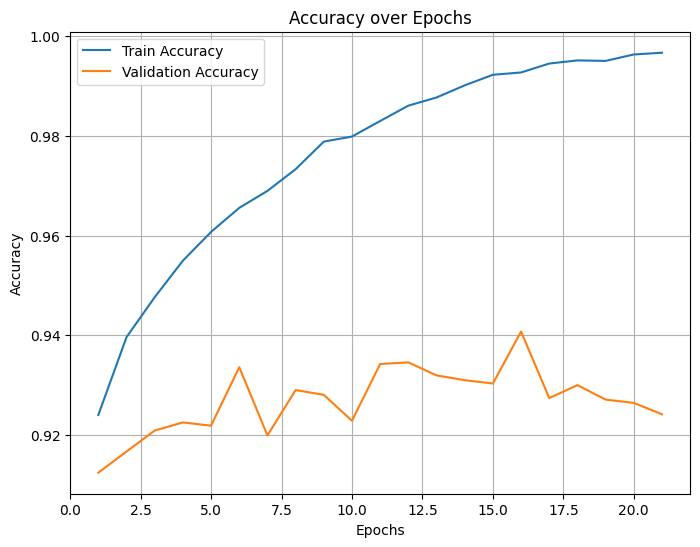

Best Train Accuracy: 0.9927114771965124, Best Validation Accuracy: 0.9407594358766234


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 259193.91it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 181591.69it/s]


start predict


5it [00:00, 58.89it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_128_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.9927114771965124_ValAcc_0.9407594358766234/submission.csv


In [8]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 128,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 128/64/3.00E-05/1.00E-08/50

In [9]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 128,
    "maxlen" : 64,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 64,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 253023.16it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 301229.54it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 99494.31it/s]


start training


training epoch 0: 100%|█████████████████████| 1491/1491 [02:28<00:00, 10.06it/s]


start predict


1491it [00:54, 27.51it/s]


start predict


8it [00:00, 29.47it/s]


Epoch 0,  Average training loss: 0.3974 , Train accuracy : 0.9209, Validation accuracy : 0.9047


training epoch 1: 100%|█████████████████████| 1491/1491 [02:29<00:00, 10.01it/s]


start predict


1491it [00:54, 27.47it/s]


start predict


8it [00:00, 29.88it/s]


Epoch 1,  Average training loss: 0.2287 , Train accuracy : 0.9388, Validation accuracy : 0.9131


training epoch 2: 100%|█████████████████████| 1491/1491 [02:28<00:00, 10.01it/s]


start predict


1491it [00:54, 27.46it/s]


start predict


8it [00:00, 29.96it/s]


Epoch 2,  Average training loss: 0.1956 , Train accuracy : 0.9471, Validation accuracy : 0.9164


training epoch 3: 100%|█████████████████████| 1491/1491 [02:29<00:00, 10.01it/s]


start predict


1491it [00:54, 27.50it/s]


start predict


8it [00:00, 30.05it/s]


Epoch 3,  Average training loss: 0.1743 , Train accuracy : 0.9547, Validation accuracy : 0.9183


training epoch 4: 100%|█████████████████████| 1491/1491 [02:28<00:00, 10.01it/s]


start predict


1491it [00:54, 27.48it/s]


start predict


8it [00:00, 30.09it/s]


Epoch 4,  Average training loss: 0.1585 , Train accuracy : 0.9596, Validation accuracy : 0.9261


training epoch 5: 100%|█████████████████████| 1491/1491 [02:28<00:00, 10.01it/s]


start predict


1491it [00:54, 27.49it/s]


start predict


8it [00:00, 30.00it/s]


Epoch 5,  Average training loss: 0.1445 , Train accuracy : 0.9650, Validation accuracy : 0.9310


training epoch 6: 100%|█████████████████████| 1491/1491 [02:28<00:00, 10.01it/s]


start predict


1491it [00:54, 27.53it/s]


start predict


8it [00:00, 30.08it/s]


Epoch 6,  Average training loss: 0.1325 , Train accuracy : 0.9694, Validation accuracy : 0.9206


training epoch 7: 100%|█████████████████████| 1491/1491 [02:28<00:00, 10.01it/s]


start predict


1491it [00:54, 27.58it/s]


start predict


8it [00:00, 30.27it/s]


Epoch 7,  Average training loss: 0.1216 , Train accuracy : 0.9743, Validation accuracy : 0.9245


training epoch 8: 100%|█████████████████████| 1491/1491 [02:28<00:00, 10.01it/s]


start predict


1491it [00:54, 27.58it/s]


start predict


8it [00:00, 30.23it/s]


Epoch 8,  Average training loss: 0.1106 , Train accuracy : 0.9783, Validation accuracy : 0.9320


training epoch 9:  57%|████████████▌         | 853/1491 [01:25<01:03,  9.98it/s]Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/dhj9842/anaconda3/envs/hai_competition/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/dhj9842/anaconda3/envs/hai_competition/lib/python3.9/site-packages/tensorboard/summary/writer/event_file_writer.py", line 244, in run
    self._run()
  File "/home/dhj9842/anaconda3/envs/hai_competition/lib/python3.9/site-packages/tensorboard/summary/writer/event_file_writer.py", line 275, in _run
    self._record_writer.write(data)
  File "/home/dhj9842/anaconda3/envs/hai_competition/lib/python3.9/site-packages/tensorboard/summary/writer/record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "/home/dhj9842/anaconda3/envs/hai_competition/lib/python3.9/site-packages/tensorboard/compat/tensorflow_stub/io/gfile.py", line 773, in write
    self.fs.append(se

FileNotFoundError: [Errno 2] No such file or directory: b'hai_kaggle/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_128_epochs_50_maxlen_64_eps_1e-08/events.out.tfevents.1691362951.dhj9842-Alienware.40872.2'

### 128/128/3.00E-05/1.00E-08/50

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:01<00:00, 190298.23it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 254541.12it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 45163.43it/s]


start training


training epoch 0: 100%|█████████████████████| 1491/1491 [04:35<00:00,  5.42it/s]


start predict


1491it [01:44, 14.29it/s]


start predict


8it [00:00, 15.41it/s]


Epoch 0,  Average training loss: 0.3942 , Train accuracy : 0.9259, Validation accuracy : 0.9121


training epoch 1: 100%|█████████████████████| 1491/1491 [04:41<00:00,  5.31it/s]


start predict


1491it [01:48, 13.80it/s]


start predict


8it [00:00, 14.94it/s]


Epoch 1,  Average training loss: 0.2239 , Train accuracy : 0.9413, Validation accuracy : 0.9200


training epoch 2: 100%|█████████████████████| 1491/1491 [04:47<00:00,  5.19it/s]


start predict


1491it [01:48, 13.78it/s]


start predict


8it [00:00, 14.85it/s]


Epoch 2,  Average training loss: 0.1912 , Train accuracy : 0.9477, Validation accuracy : 0.9173


training epoch 3: 100%|█████████████████████| 1491/1491 [04:37<00:00,  5.36it/s]


start predict


1491it [01:44, 14.27it/s]


start predict


8it [00:00, 15.20it/s]


Epoch 3,  Average training loss: 0.1707 , Train accuracy : 0.9561, Validation accuracy : 0.9186


training epoch 4: 100%|█████████████████████| 1491/1491 [04:36<00:00,  5.39it/s]


start predict


1491it [01:44, 14.26it/s]


start predict


8it [00:00, 15.29it/s]


Epoch 4,  Average training loss: 0.1548 , Train accuracy : 0.9621, Validation accuracy : 0.9219


training epoch 5: 100%|█████████████████████| 1491/1491 [04:36<00:00,  5.40it/s]


start predict


1491it [01:44, 14.27it/s]


start predict


8it [00:00, 15.31it/s]


Epoch 5,  Average training loss: 0.1400 , Train accuracy : 0.9658, Validation accuracy : 0.9255


training epoch 6: 100%|█████████████████████| 1491/1491 [04:36<00:00,  5.40it/s]


start predict


1491it [01:46, 13.94it/s]


start predict


8it [00:00, 14.91it/s]


Epoch 6,  Average training loss: 0.1280 , Train accuracy : 0.9704, Validation accuracy : 0.9209


training epoch 7: 100%|█████████████████████| 1491/1491 [04:46<00:00,  5.20it/s]


start predict


1491it [01:48, 13.75it/s]


start predict


8it [00:00, 14.78it/s]


Epoch 7,  Average training loss: 0.1181 , Train accuracy : 0.9759, Validation accuracy : 0.9287


training epoch 8: 100%|█████████████████████| 1491/1491 [04:46<00:00,  5.20it/s]


start predict


1491it [01:48, 13.73it/s]


start predict


8it [00:00, 14.83it/s]


Epoch 8,  Average training loss: 0.1079 , Train accuracy : 0.9797, Validation accuracy : 0.9268


training epoch 9: 100%|█████████████████████| 1491/1491 [04:46<00:00,  5.21it/s]


start predict


1491it [01:48, 13.76it/s]


start predict


8it [00:00, 14.87it/s]


Epoch 9,  Average training loss: 0.0991 , Train accuracy : 0.9813, Validation accuracy : 0.9297


training epoch 10: 100%|████████████████████| 1491/1491 [04:46<00:00,  5.21it/s]


start predict


1491it [01:48, 13.73it/s]


start predict


8it [00:00, 14.76it/s]


Epoch 10,  Average training loss: 0.0915 , Train accuracy : 0.9845, Validation accuracy : 0.9261


training epoch 11: 100%|████████████████████| 1491/1491 [04:47<00:00,  5.19it/s]


start predict


1491it [01:48, 13.68it/s]


start predict


8it [00:00, 14.53it/s]


Epoch 11,  Average training loss: 0.0835 , Train accuracy : 0.9875, Validation accuracy : 0.9336


training epoch 12: 100%|████████████████████| 1491/1491 [04:47<00:00,  5.19it/s]


start predict


1491it [01:48, 13.70it/s]


start predict


8it [00:00, 14.69it/s]


Epoch 12,  Average training loss: 0.0772 , Train accuracy : 0.9880, Validation accuracy : 0.9300


training epoch 13: 100%|████████████████████| 1491/1491 [04:48<00:00,  5.18it/s]


start predict


1491it [01:48, 13.75it/s]


start predict


8it [00:00, 14.62it/s]


Epoch 13,  Average training loss: 0.0712 , Train accuracy : 0.9907, Validation accuracy : 0.9317


training epoch 14: 100%|████████████████████| 1491/1491 [04:46<00:00,  5.20it/s]


start predict


1491it [01:48, 13.76it/s]


start predict


8it [00:00, 14.79it/s]


Epoch 14,  Average training loss: 0.0654 , Train accuracy : 0.9923, Validation accuracy : 0.9251


training epoch 15: 100%|████████████████████| 1491/1491 [04:46<00:00,  5.20it/s]


start predict


1491it [01:48, 13.74it/s]


start predict


8it [00:00, 14.93it/s]


Epoch 15,  Average training loss: 0.0612 , Train accuracy : 0.9934, Validation accuracy : 0.9294


training epoch 16: 100%|████████████████████| 1491/1491 [04:47<00:00,  5.19it/s]


start predict


1491it [01:48, 13.77it/s]


start predict


8it [00:00, 14.65it/s]


Epoch 16,  Average training loss: 0.0570 , Train accuracy : 0.9943, Validation accuracy : 0.9297


training epoch 17: 100%|████████████████████| 1491/1491 [04:46<00:00,  5.20it/s]


start predict


1491it [01:48, 13.77it/s]


start predict


8it [00:00, 14.94it/s]


Epoch 17,  Average training loss: 0.0525 , Train accuracy : 0.9957, Validation accuracy : 0.9261


training epoch 18: 100%|████████████████████| 1491/1491 [04:46<00:00,  5.20it/s]


start predict


1491it [01:48, 13.69it/s]


start predict


8it [00:00, 14.61it/s]


Epoch 18,  Average training loss: 0.0490 , Train accuracy : 0.9959, Validation accuracy : 0.9310


training epoch 19: 100%|████████████████████| 1491/1491 [04:47<00:00,  5.18it/s]


start predict


1491it [01:48, 13.70it/s]


start predict


8it [00:00, 14.67it/s]


Epoch 19,  Average training loss: 0.0464 , Train accuracy : 0.9962, Validation accuracy : 0.9209


training epoch 20: 100%|████████████████████| 1491/1491 [04:47<00:00,  5.19it/s]


start predict


1491it [01:48, 13.72it/s]


start predict


8it [00:00, 14.69it/s]


Epoch 20,  Average training loss: 0.0422 , Train accuracy : 0.9962, Validation accuracy : 0.9274


training epoch 21: 100%|████████████████████| 1491/1491 [04:47<00:00,  5.19it/s]


start predict


1491it [01:48, 13.73it/s]


start predict


8it [00:00, 14.77it/s]


Epoch 21,  Average training loss: 0.0412 , Train accuracy : 0.9972, Validation accuracy : 0.9300
[Early Stopping]10 epoch에서 중단.[Early Stopping]


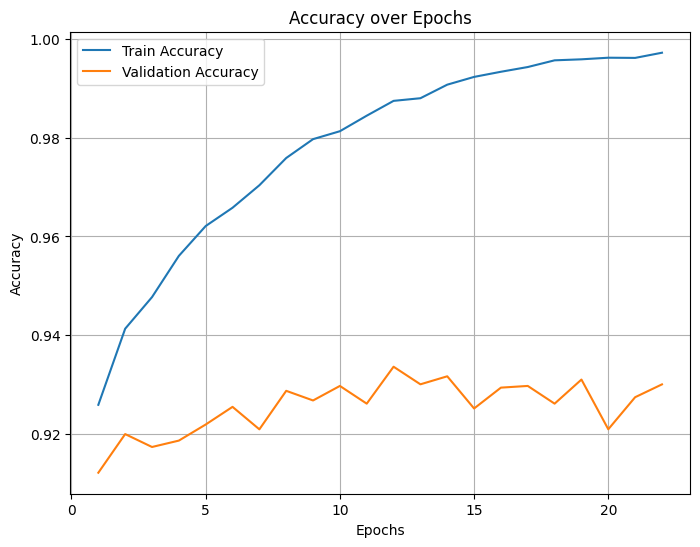

Best Train Accuracy: 0.987455985915493, Best Validation Accuracy: 0.9336064326298701


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 247095.27it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 626/626 [00:00<00:00, 45257.07it/s]


start predict


5it [00:00, 14.61it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_128_epochs_50_maxlen_128_eps_1e-08_TrainAcc_0.987455985915493_ValAcc_0.9336064326298701/submission.csv


In [14]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 128,
    "maxlen" : 128,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 128,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 256/32/3.00E-05/1.00E-08/20

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 223325.73it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 274929.79it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 163281.50it/s]


start training


training epoch 0: 100%|███████████████████████| 746/746 [01:12<00:00, 10.32it/s]


start predict


746it [00:26, 28.52it/s]


start predict


4it [00:00, 31.31it/s]


Epoch 0,  Average training loss: 0.4850 , Train accuracy : 0.9186, Validation accuracy : 0.9073


training epoch 1: 100%|███████████████████████| 746/746 [01:12<00:00, 10.22it/s]


start predict


746it [00:26, 28.64it/s]


start predict


4it [00:00, 31.40it/s]


Epoch 1,  Average training loss: 0.2493 , Train accuracy : 0.9336, Validation accuracy : 0.9231


training epoch 2: 100%|███████████████████████| 746/746 [01:13<00:00, 10.20it/s]


start predict


746it [00:26, 28.54it/s]


start predict


4it [00:00, 30.92it/s]


Epoch 2,  Average training loss: 0.2136 , Train accuracy : 0.9409, Validation accuracy : 0.9226


training epoch 3: 100%|███████████████████████| 746/746 [01:13<00:00, 10.18it/s]


start predict


746it [00:26, 28.46it/s]


start predict


4it [00:00, 31.28it/s]


Epoch 3,  Average training loss: 0.1925 , Train accuracy : 0.9470, Validation accuracy : 0.9214


training epoch 4: 100%|███████████████████████| 746/746 [01:13<00:00, 10.14it/s]


start predict


746it [00:26, 28.39it/s]


start predict


4it [00:00, 30.83it/s]


Epoch 4,  Average training loss: 0.1781 , Train accuracy : 0.9529, Validation accuracy : 0.9263


training epoch 5: 100%|███████████████████████| 746/746 [01:13<00:00, 10.16it/s]


start predict


746it [00:26, 28.29it/s]


start predict


4it [00:00, 30.10it/s]


Epoch 5,  Average training loss: 0.1658 , Train accuracy : 0.9561, Validation accuracy : 0.9265


training epoch 6: 100%|███████████████████████| 746/746 [01:13<00:00, 10.14it/s]


start predict


746it [00:26, 28.28it/s]


start predict


4it [00:00, 30.16it/s]


Epoch 6,  Average training loss: 0.1545 , Train accuracy : 0.9601, Validation accuracy : 0.9270


training epoch 7: 100%|███████████████████████| 746/746 [01:13<00:00, 10.13it/s]


start predict


746it [00:26, 28.16it/s]


start predict


4it [00:00, 30.70it/s]


Epoch 7,  Average training loss: 0.1456 , Train accuracy : 0.9643, Validation accuracy : 0.9292


training epoch 8: 100%|███████████████████████| 746/746 [01:14<00:00, 10.08it/s]


start predict


746it [00:26, 28.18it/s]


start predict


4it [00:00, 31.03it/s]


Epoch 8,  Average training loss: 0.1371 , Train accuracy : 0.9658, Validation accuracy : 0.9314


training epoch 9: 100%|███████████████████████| 746/746 [01:14<00:00, 10.08it/s]


start predict


746it [00:26, 28.11it/s]


start predict


4it [00:00, 30.76it/s]


Epoch 9,  Average training loss: 0.1307 , Train accuracy : 0.9688, Validation accuracy : 0.9341


training epoch 10: 100%|██████████████████████| 746/746 [01:14<00:00, 10.04it/s]


start predict


746it [00:26, 28.16it/s]


start predict


4it [00:00, 30.48it/s]


Epoch 10,  Average training loss: 0.1253 , Train accuracy : 0.9713, Validation accuracy : 0.9343


training epoch 11: 100%|██████████████████████| 746/746 [01:14<00:00, 10.06it/s]


start predict


746it [00:26, 28.09it/s]


start predict


4it [00:00, 30.17it/s]


Epoch 11,  Average training loss: 0.1196 , Train accuracy : 0.9734, Validation accuracy : 0.9348


training epoch 12: 100%|██████████████████████| 746/746 [01:14<00:00, 10.04it/s]


start predict


746it [00:26, 28.13it/s]


start predict


4it [00:00, 31.18it/s]


Epoch 12,  Average training loss: 0.1139 , Train accuracy : 0.9744, Validation accuracy : 0.9343


training epoch 13: 100%|██████████████████████| 746/746 [01:14<00:00, 10.04it/s]


start predict


746it [00:26, 28.08it/s]


start predict


4it [00:00, 30.51it/s]


Epoch 13,  Average training loss: 0.1099 , Train accuracy : 0.9762, Validation accuracy : 0.9348


training epoch 14: 100%|██████████████████████| 746/746 [01:13<00:00, 10.08it/s]


start predict


746it [00:26, 28.23it/s]


start predict


4it [00:00, 31.11it/s]


Epoch 14,  Average training loss: 0.1048 , Train accuracy : 0.9774, Validation accuracy : 0.9275


training epoch 15: 100%|██████████████████████| 746/746 [01:13<00:00, 10.12it/s]


start predict


746it [00:26, 28.22it/s]


start predict


4it [00:00, 30.83it/s]


Epoch 15,  Average training loss: 0.1018 , Train accuracy : 0.9792, Validation accuracy : 0.9336


training epoch 16: 100%|██████████████████████| 746/746 [01:13<00:00, 10.12it/s]


start predict


746it [00:26, 28.27it/s]


start predict


4it [00:00, 31.00it/s]


Epoch 16,  Average training loss: 0.0990 , Train accuracy : 0.9793, Validation accuracy : 0.9356


training epoch 17: 100%|██████████████████████| 746/746 [01:13<00:00, 10.14it/s]


start predict


746it [00:26, 28.24it/s]


start predict


4it [00:00, 30.76it/s]


Epoch 17,  Average training loss: 0.0963 , Train accuracy : 0.9803, Validation accuracy : 0.9358


training epoch 18: 100%|██████████████████████| 746/746 [01:13<00:00, 10.12it/s]


start predict


746it [00:26, 28.27it/s]


start predict


4it [00:00, 31.05it/s]


Epoch 18,  Average training loss: 0.0946 , Train accuracy : 0.9807, Validation accuracy : 0.9326


training epoch 19: 100%|██████████████████████| 746/746 [01:13<00:00, 10.13it/s]


start predict


746it [00:26, 28.23it/s]


start predict


4it [00:00, 31.23it/s]


Epoch 19,  Average training loss: 0.0944 , Train accuracy : 0.9809, Validation accuracy : 0.9343


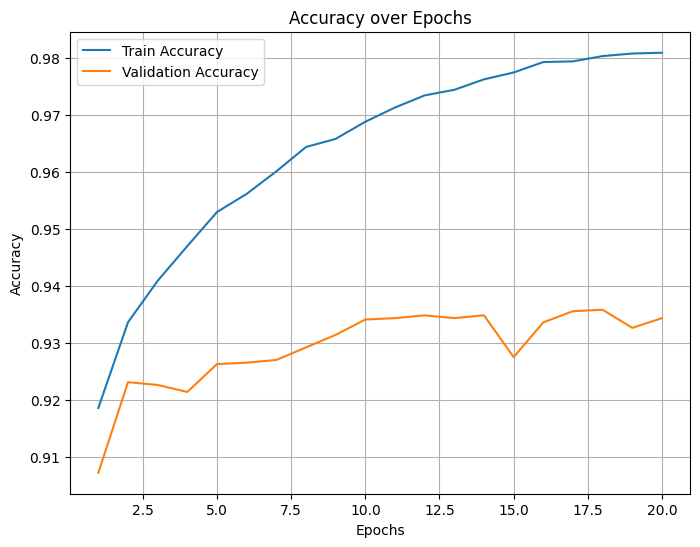

Best Train Accuracy: 0.9802697721179625, Best Validation Accuracy: 0.9358088795731707


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 263962.43it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 163846.13it/s]


start predict


3it [00:00, 37.28it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_256_epochs_20_maxlen_32_eps_1e-08_TrainAcc_0.9802697721179625_ValAcc_0.9358088795731707/submission.csv


In [9]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 256,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 20,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 256,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 256/128/3.00E-05/1.00E-08/20

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 229006.74it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 282211.31it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 973/973 [00:00<00:00, 45902.03it/s]


start training


training epoch 0: 100%|███████████████████████| 746/746 [04:34<00:00,  2.71it/s]


start predict


746it [01:46,  7.02it/s]


start predict


4it [00:00,  7.55it/s]


Epoch 0,  Average training loss: 0.4619 , Train accuracy : 0.9202, Validation accuracy : 0.9087


training epoch 1: 100%|███████████████████████| 746/746 [04:36<00:00,  2.70it/s]


start predict


746it [01:46,  7.02it/s]


start predict


4it [00:00,  7.57it/s]


Epoch 1,  Average training loss: 0.2427 , Train accuracy : 0.9354, Validation accuracy : 0.9116


training epoch 2: 100%|███████████████████████| 746/746 [04:37<00:00,  2.69it/s]


start predict


746it [01:46,  6.98it/s]


start predict


4it [00:00,  6.85it/s]


Epoch 2,  Average training loss: 0.2081 , Train accuracy : 0.9423, Validation accuracy : 0.9151


training epoch 3: 100%|███████████████████████| 746/746 [04:38<00:00,  2.68it/s]


start predict


746it [01:47,  6.96it/s]


start predict


4it [00:00,  7.51it/s]


Epoch 3,  Average training loss: 0.1894 , Train accuracy : 0.9479, Validation accuracy : 0.9216


training epoch 4: 100%|███████████████████████| 746/746 [04:39<00:00,  2.67it/s]


start predict


746it [01:49,  6.84it/s]


start predict


4it [00:00,  7.37it/s]


Epoch 4,  Average training loss: 0.1741 , Train accuracy : 0.9532, Validation accuracy : 0.9241


training epoch 5: 100%|███████████████████████| 746/746 [04:42<00:00,  2.64it/s]


start predict


746it [01:49,  6.83it/s]


start predict


4it [00:00,  7.35it/s]


Epoch 5,  Average training loss: 0.1612 , Train accuracy : 0.9569, Validation accuracy : 0.9209


training epoch 6: 100%|███████████████████████| 746/746 [04:43<00:00,  2.64it/s]


start predict


746it [01:49,  6.82it/s]


start predict


4it [00:00,  7.32it/s]


Epoch 6,  Average training loss: 0.1515 , Train accuracy : 0.9612, Validation accuracy : 0.9253


training epoch 7: 100%|███████████████████████| 746/746 [04:43<00:00,  2.64it/s]


start predict


746it [01:49,  6.81it/s]


start predict


4it [00:00,  7.34it/s]


Epoch 7,  Average training loss: 0.1423 , Train accuracy : 0.9650, Validation accuracy : 0.9275


training epoch 8: 100%|███████████████████████| 746/746 [04:43<00:00,  2.63it/s]


start predict


746it [01:49,  6.80it/s]


start predict


4it [00:00,  7.33it/s]


Epoch 8,  Average training loss: 0.1356 , Train accuracy : 0.9666, Validation accuracy : 0.9307


training epoch 9: 100%|███████████████████████| 746/746 [04:43<00:00,  2.64it/s]


start predict


746it [01:49,  6.79it/s]


start predict


4it [00:00,  7.29it/s]


Epoch 9,  Average training loss: 0.1280 , Train accuracy : 0.9694, Validation accuracy : 0.9299


training epoch 10: 100%|██████████████████████| 746/746 [04:43<00:00,  2.63it/s]


start predict


746it [01:49,  6.79it/s]


start predict


4it [00:00,  7.31it/s]


Epoch 10,  Average training loss: 0.1216 , Train accuracy : 0.9718, Validation accuracy : 0.9204


training epoch 11: 100%|██████████████████████| 746/746 [04:43<00:00,  2.63it/s]


start predict


746it [01:49,  6.79it/s]


start predict


4it [00:00,  7.30it/s]


Epoch 11,  Average training loss: 0.1160 , Train accuracy : 0.9740, Validation accuracy : 0.9263


training epoch 12: 100%|██████████████████████| 746/746 [04:43<00:00,  2.63it/s]


start predict


746it [01:49,  6.78it/s]


start predict


4it [00:00,  7.32it/s]


Epoch 12,  Average training loss: 0.1107 , Train accuracy : 0.9758, Validation accuracy : 0.9268


training epoch 13: 100%|██████████████████████| 746/746 [04:43<00:00,  2.63it/s]


start predict


746it [01:49,  6.81it/s]


start predict


4it [00:00,  7.36it/s]


Epoch 13,  Average training loss: 0.1060 , Train accuracy : 0.9772, Validation accuracy : 0.9304
[Early Stopping]5 epoch에서 중단.[Early Stopping]


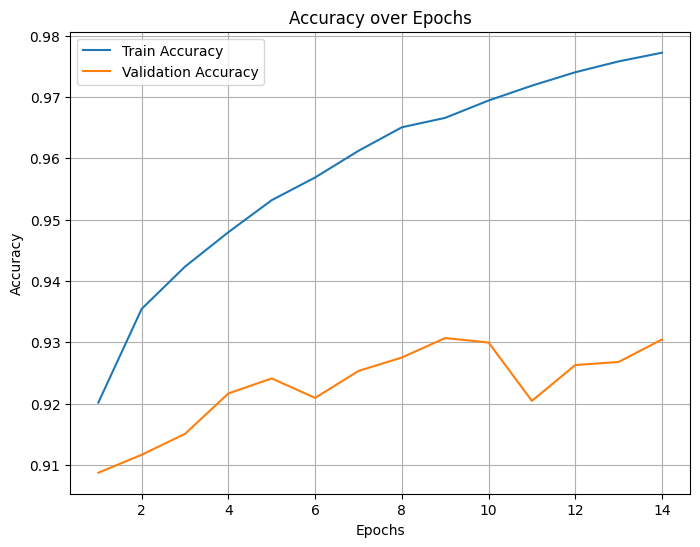

Best Train Accuracy: 0.9665821883378016, Best Validation Accuracy: 0.9306783536585366


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 248075.80it/s]


Padding sequences...


Generating attention masks: 100%|██████████| 626/626 [00:00<00:00, 46143.09it/s]


start predict


3it [00:00,  8.91it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-small-v3-discriminator_lr_3e-05_batch_256_epochs_20_maxlen_128_eps_1e-08_TrainAcc_0.9665821883378016_ValAcc_0.9306783536585366/submission.csv


In [10]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 256,
    "maxlen" : 128,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 20,
    "model_ckpt" : "monologg/koelectra-small-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 256,
  "maxlen" : 128,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

## koelectra-base-v3-discriminator

### 64/32/3.00E-05/1.00E-08/1

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 221760.85it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 263685.33it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 159248.36it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:07, 15.89it/s]


start predict


16it [00:00, 16.86it/s]


Epoch 0,  Average training loss: 0.2474 , Train accuracy : 0.9477, Validation accuracy : 0.9191


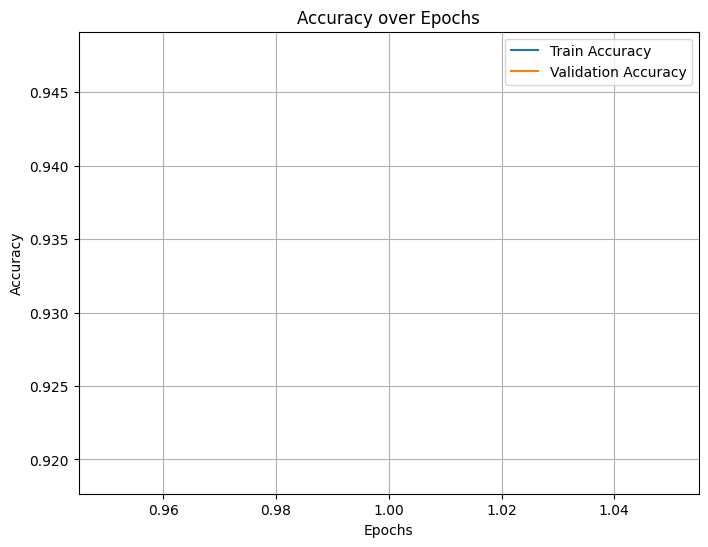

Best Train Accuracy: 0.9476968718550821, Best Validation Accuracy: 0.9190955528846154


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 237377.66it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 165155.01it/s]


start predict


10it [00:00, 16.75it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-base-v3-discriminator_lr_3e-05_batch_64_epochs_1_maxlen_32_eps_1e-08_TrainAcc_0.9476968718550821_ValAcc_0.9190955528846154/submission.csv


In [15]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 1,
    "model_ckpt" : "monologg/koelectra-base-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 64/32/3.00E-03/1.00E-08/50

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:01<00:00, 187914.37it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 230282.01it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 164671.66it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [09:14<00:00,  5.37it/s]


start predict


2981it [03:07, 15.87it/s]


start predict


16it [00:00, 16.93it/s]


Epoch 0,  Average training loss: 0.2499 , Train accuracy : 0.9496, Validation accuracy : 0.9152


training epoch 1: 100%|█████████████████████| 2981/2981 [09:16<00:00,  5.35it/s]


start predict


2981it [03:08, 15.85it/s]


start predict


16it [00:00, 16.91it/s]


Epoch 1,  Average training loss: 0.1588 , Train accuracy : 0.9673, Validation accuracy : 0.9355


training epoch 2: 100%|█████████████████████| 2981/2981 [09:14<00:00,  5.38it/s]


start predict


2981it [03:05, 16.05it/s]


start predict


16it [00:00, 17.04it/s]


Epoch 2,  Average training loss: 0.1146 , Train accuracy : 0.9812, Validation accuracy : 0.9326


training epoch 3: 100%|█████████████████████| 2981/2981 [09:14<00:00,  5.38it/s]


start predict


2981it [03:05, 16.04it/s]


start predict


16it [00:00, 17.06it/s]


Epoch 3,  Average training loss: 0.0837 , Train accuracy : 0.9901, Validation accuracy : 0.9162


training epoch 4: 100%|█████████████████████| 2981/2981 [09:13<00:00,  5.39it/s]


start predict


2981it [03:05, 16.07it/s]


start predict


16it [00:00, 17.06it/s]


Epoch 4,  Average training loss: 0.0626 , Train accuracy : 0.9932, Validation accuracy : 0.9355


training epoch 5: 100%|█████████████████████| 2981/2981 [09:15<00:00,  5.37it/s]


start predict


2981it [03:07, 15.93it/s]


start predict


16it [00:00, 17.03it/s]


Epoch 5,  Average training loss: 0.0494 , Train accuracy : 0.9951, Validation accuracy : 0.9239


training epoch 6: 100%|█████████████████████| 2981/2981 [09:16<00:00,  5.35it/s]


start predict


2981it [03:06, 15.98it/s]


start predict


16it [00:00, 16.93it/s]


Epoch 6,  Average training loss: 0.0387 , Train accuracy : 0.9958, Validation accuracy : 0.9239


training epoch 7: 100%|█████████████████████| 2981/2981 [09:17<00:00,  5.34it/s]


start predict


2981it [03:06, 15.99it/s]


start predict


16it [00:00, 16.90it/s]


Epoch 7,  Average training loss: 0.0328 , Train accuracy : 0.9973, Validation accuracy : 0.9336


training epoch 8: 100%|█████████████████████| 2981/2981 [09:16<00:00,  5.35it/s]


start predict


2981it [03:06, 16.00it/s]


start predict


16it [00:00, 16.88it/s]


Epoch 8,  Average training loss: 0.0293 , Train accuracy : 0.9978, Validation accuracy : 0.9171


training epoch 9: 100%|█████████████████████| 2981/2981 [09:16<00:00,  5.35it/s]


start predict


2981it [03:06, 15.98it/s]


start predict


16it [00:00, 16.99it/s]


Epoch 9,  Average training loss: 0.0254 , Train accuracy : 0.9974, Validation accuracy : 0.9326


training epoch 10: 100%|████████████████████| 2981/2981 [09:16<00:00,  5.35it/s]


start predict


2981it [03:06, 15.98it/s]


start predict


16it [00:00, 16.90it/s]


Epoch 10,  Average training loss: 0.0220 , Train accuracy : 0.9980, Validation accuracy : 0.9277


training epoch 11: 100%|████████████████████| 2981/2981 [09:16<00:00,  5.35it/s]


start predict


2981it [03:06, 15.98it/s]


start predict


16it [00:00, 16.92it/s]

Epoch 11,  Average training loss: 0.0200 , Train accuracy : 0.9985, Validation accuracy : 0.9277
[Early Stopping]10 epoch에서 중단.[Early Stopping]


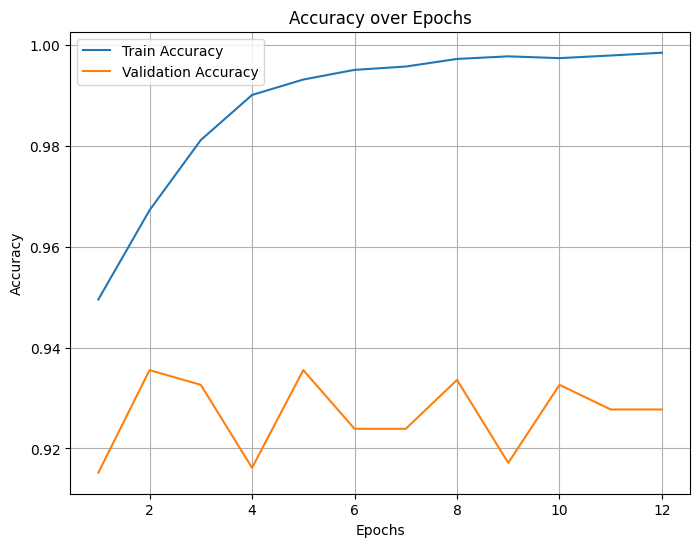

Best Train Accuracy: 0.9672718886279772, Best Validation Accuracy: 0.935546875


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 239499.62it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 168266.75it/s]


start predict


10it [00:00, 16.97it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_monologg_koelectra-base-v3-discriminator_lr_3e-05_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.9672718886279772_ValAcc_0.935546875/submission.csv


In [16]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "monologg/koelectra-base-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 128/32/3.00E-03/1.00E-08/20

In [11]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 128,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 20,
    "model_ckpt" : "monologg/koelectra-base-v3-discriminator",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 225455.48it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 271292.81it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 166329.39it/s]


start training


training epoch 0: 100%|█████████████████████| 1491/1491 [08:12<00:00,  3.03it/s]


start predict


1491it [03:07,  7.95it/s]


start predict


8it [00:00,  8.45it/s]


Epoch 0,  Average training loss: 0.2634 , Train accuracy : 0.9444, Validation accuracy : 0.9258


training epoch 1: 100%|█████████████████████| 1491/1491 [08:12<00:00,  3.03it/s]


start predict


1491it [03:06,  7.97it/s]


start predict


8it [00:00,  8.49it/s]


Epoch 1,  Average training loss: 0.1628 , Train accuracy : 0.9653, Validation accuracy : 0.9291


training epoch 2: 100%|█████████████████████| 1491/1491 [07:59<00:00,  3.11it/s]


start predict


1491it [03:06,  7.99it/s]


start predict


8it [00:00,  8.51it/s]


Epoch 2,  Average training loss: 0.1203 , Train accuracy : 0.9772, Validation accuracy : 0.9343


training epoch 3: 100%|█████████████████████| 1491/1491 [08:11<00:00,  3.04it/s]


start predict


1491it [03:06,  7.98it/s]


start predict


8it [00:00,  8.49it/s]


Epoch 3,  Average training loss: 0.0899 , Train accuracy : 0.9873, Validation accuracy : 0.9336


training epoch 4: 100%|█████████████████████| 1491/1491 [08:11<00:00,  3.03it/s]


start predict


1491it [03:07,  7.97it/s]


start predict


8it [00:00,  8.47it/s]


Epoch 4,  Average training loss: 0.0656 , Train accuracy : 0.9926, Validation accuracy : 0.9278


training epoch 5: 100%|█████████████████████| 1491/1491 [08:11<00:00,  3.03it/s]


start predict


1491it [03:07,  7.97it/s]


start predict


8it [00:00,  8.48it/s]


Epoch 5,  Average training loss: 0.0482 , Train accuracy : 0.9954, Validation accuracy : 0.9369


training epoch 6: 100%|█████████████████████| 1491/1491 [07:59<00:00,  3.11it/s]


start predict


1491it [03:01,  8.23it/s]


start predict


8it [00:00,  8.73it/s]


Epoch 6,  Average training loss: 0.0370 , Train accuracy : 0.9972, Validation accuracy : 0.9336


training epoch 7: 100%|█████████████████████| 1491/1491 [07:59<00:00,  3.11it/s]


start predict


1491it [03:01,  8.23it/s]


start predict


8it [00:00,  8.74it/s]


Epoch 7,  Average training loss: 0.0295 , Train accuracy : 0.9981, Validation accuracy : 0.9365


training epoch 8: 100%|█████████████████████| 1491/1491 [08:00<00:00,  3.11it/s]


start predict


1491it [03:02,  8.16it/s]


start predict


8it [00:00,  8.66it/s]


Epoch 8,  Average training loss: 0.0240 , Train accuracy : 0.9972, Validation accuracy : 0.9369


training epoch 9: 100%|█████████████████████| 1491/1491 [08:02<00:00,  3.09it/s]


start predict


1491it [03:01,  8.20it/s]


start predict


8it [00:00,  8.75it/s]


Epoch 9,  Average training loss: 0.0197 , Train accuracy : 0.9987, Validation accuracy : 0.9375


training epoch 10: 100%|████████████████████| 1491/1491 [08:00<00:00,  3.10it/s]


start predict


1491it [03:01,  8.20it/s]


start predict


8it [00:00,  8.75it/s]


Epoch 10,  Average training loss: 0.0168 , Train accuracy : 0.9990, Validation accuracy : 0.9356


training epoch 11: 100%|████████████████████| 1491/1491 [13:18<00:00,  1.87it/s]


start predict


1491it [07:42,  3.22it/s]


start predict


8it [00:02,  3.41it/s]


Epoch 11,  Average training loss: 0.0141 , Train accuracy : 0.9990, Validation accuracy : 0.9365


training epoch 12:  33%|██████▊              | 487/1491 [08:17<17:06,  1.02s/it]


KeyboardInterrupt: 

## kobert

### 128/128/1.00E-03/1.00E-08/1

In [ ]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 128,
    "maxlen" : 64,
    "lr" : 1e-3,
    "eps" : 1e-8,
    "epochs" : 1,
    "model_ckpt" : "monologg/kobert",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 128,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 128/128/3.00E-05/1.00E-08/1

In [ ]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 128,
    "maxlen" : 64,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 1,
    "model_ckpt" : "monologg/kobert",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 128,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

### 128/32/3.00E-05/1.00E-08/10

In [ ]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 128,
    "maxlen" : 32,
    "lr" : 3e-5,
    "eps" : 1e-8,
    "epochs" : 10,
    "model_ckpt" : "monologg/kobert",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 128,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)

# Error Issue

---

## ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']

*Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at monologg/distilkobert and are newly 

initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.*

### chatgpt

이 메시지는 DistilBertForSequenceClassification 모델의 일부 가중치가 사전 훈련된 모델 체크포인트('monologg/distilkobert')에서 초기화되지 않았음을 알려주는 경고 메시지입니다. 이는 특정 모델 구조에서 추가적인 레이어나 파라미터가 있는 경우 발생하는데, 특히 분류 작업을 위해 모델의 출력 레이어에 선형 레이어를 추가하는 경우에 이런 현상이 발생합니다.

구체적으로 말하면, 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias' 이 네 가중치는 분류 작업에 사용되는 추가적인 레이어에 속하는 가중치입니다. 사전 훈련된 모델 체크포인트에는 이러한 가중치들이 없으므로, 이들은 임의의 값으로 초기화되고, 모델을 학습하는 동안 이들 가중치는 데이터로부터 학습됩니다.

따라서 이 경고 메시지는 사전 훈련된 모델 체크포인트가 분류 작업에 직접 사용될 수 없으며, 해당 모델을 하위 작업에서 추가로 훈련해야 한다는 것을 알려줍니다. 이것은 보통의 워크플로우로, 사전 훈련된 모델을 특정 작업에 맞게 미세 조정하기 위해 사용됩니다. 이 경고 메시지는 모델이 정상적으로 작동하지 않는다는 것을 의미하지 않습니다.

*Q. 결국에는 학습시에는 상관없다는 의미 아닌가?*

네, 맞습니다. 이 경고 메시지는 분류 작업을 위한 추가적인 레이어의 가중치들이 랜덤하게 초기화되었다는 것을 알려주는 것이며, 이는 정상적인 작업 흐름에 속합니다.

이런 가중치들은 모델을 하위 작업에서 학습하면서 업데이트될 것입니다. 따라서 이 메시지는 모델을 학습하기 전에 경고로 주어지는 것이며, 이후의 학습 과정에는 영향을 미치지 않습니다.

이 메시지가 나타나더라도 모델 학습을 계속 진행할 수 있습니다.

---
## RuntimeError: CUDA error: device-side assert triggered

### chatgpt(실패)

RuntimeError: CUDA error: device-side assert triggered

CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.

For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

### 블로그 참고(성공)

- https://mopipe.tistory.com/180
    - index를 중간에 잘못 생성해서, 이로 인해 예측과 학습 간의 인덱스가 이상하게 형성됨
    - 편리성을 위해 함수화하는 과정에서 전달하는 인자값 매핑 오류도 있었음

---
### Out of Memory

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 15.75 GiB total capacity; 14.06 GiB already allocated;

174.88 MiB free; 14.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to 

avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

- 내 gpu가 수용 가능한 데이터를 넘었을 때 주로 발생한다.
    - 즉, 내가 밀어주는 데이터와 배치사이즈 크기에 영향을 받는다.
    - 이에 따라, 배치 사이즈를 줄여주거나, 더 많은 자원을 할당해줌으로써 해결 가능하다.
    - 이 때, 터미널에서 'nvidia-smi -l 1'을 쳐보면 실시간 gpu 사용량을 볼 수 있는데 거의 꽉 차 있는 것이 확인 가능하다.
    - 이 때, Ubuntu기준으로 'ps aux | grep python'을 치면 현재 파이썬에서 활용하고 있는 자원이 나온다.(혹은 위 nvidia 명령어 아래에도 사용량이 나온다)
    - 이에 해당하는 PID번호를 확인하고 'sudo kill -9 PID'로 해당 자원을 내리면 해결된다.
    - 이 다음 파라미터를 다시 조정하고 테스트 해본다.

---
## The other

- jax와 같은 다른 고성능 딥러닝 프레임워크를 아직 써본 적이 없는데, 차후 도전 예정